In [87]:
import pandas as pd
import numpy as np
seed = 0
np.random.seed(seed)
%load_ext autoreload
%autoreload 2

In [2]:
#loading fraud dataset
df = pd.read_csv('https://query.data.world/s/kh37dhn6dcuz4ktsndak2a5hynrbvm')

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df['Class'].sum()

492

In [6]:
#class imbalance
df['Class'].sum()/df.shape[0]

0.001727485630620034

In [ ]:
from sklearn.model_selection import train_test_split

In [330]:
from sklearn.preprocessing import PolynomialFeatures 

In [334]:
pf = PolynomialFeatures(degree=2)

In [335]:
X = df.values[:,:-1]
y = df.values[:,-1]
X = pf.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=seed)

In [337]:
#downsampling in order to balance the classes

#getting the indexes of the classes
index_0 = np.where(y_train == 0)[0]
index_1 = np.where(y_train == 1)[0]

#counting how many rows in each class
n_0 = len(index_0)
n_1 = len(index_1)

#randomly sampling the index of class 0 (the majority class0) until we have equal number of indexes for each class
index_0_downsampled = np.random.choice(index_0, size=n_1, replace=False)

#stacking the ys and Xs horizontally then vertically
class_0 = np.hstack((y_train[index_0_downsampled].reshape(-1,1), X_train[index_0_downsampled]))
class_1 = np.hstack((y_train[index_1].reshape(-1,1), X_train[index_1]))
data = np.vstack([class_0,class_1])
np.random.shuffle(data)

#creating a new X and y
y_train = data[:,0]
X_train = data[:,1:]

In [338]:
#class balance now
y_train.sum()/X_train.shape[0]

0.5

In [339]:
y_train.sum()

418.0

In [340]:
from xgboost.sklearn import XGBClassifier

In [341]:
learning_rate = [0.2,0.25,0.3,0.4] #0.05,0.1,0.15,,0.5
gamma = [0,2,5,8] #1,3,4,,6,7
max_depth = [1,3,5] #7
min_child_weight = [0,2]
max_delta_step = [0,3] #1,5
reg_lambda = [0.01,1,10] #0.001,0.1
reg_alpha = [0.01,1,10] 
colsample_bytree = [0.8] #0.5,0.7,1
subsample = [0.8] #0.5,0.7,1
objective = ['binary:logistic']
nthread = [-1]

In [342]:
param_dict = dict(learning_rate = learning_rate,
                  gamma = gamma,
                  max_depth = max_depth,
                  min_child_weight = min_child_weight,
                  max_delta_step = max_delta_step,
                  reg_lambda = reg_lambda,
                  reg_alpha = reg_alpha,
                  colsample_bytree = colsample_bytree,
                  subsample = subsample,
                  objective = objective,
                  nthread = nthread)

In [343]:
from sklearn.model_selection import GridSearchCV

In [344]:
xgb = XGBClassifier()
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_dict,
                    n_jobs=-1,
                    scoring='f1',
                    cv=5,
                    verbose=1)

In [345]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 43.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.2, 0.25, 0.3, 0.4], 'gamma': [0, 2, 5, 8], 'max_depth': [1, 3, 5], 'min_child_weight': [0, 2], 'max_delta_step': [0, 3], 'reg_lambda': [0.01, 1, 10], 'reg_alpha': [0.01, 1, 10], 'colsample_bytree': [0.8], 'subsample': [0.8], 'objective': ['binary:logistic'], 'nthread': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [346]:
grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 0,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 0.8}

In [347]:
grid.best_score_

0.9422492220510394

In [348]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [349]:
xgb = XGBClassifier(**grid.best_params_)

In [350]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=3,
       max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [351]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

In [352]:
print("Accuracy: %0.3f" %(accuracy_score(y_test,y_pred)))
print("Precision: %0.3f" %(precision_score(y_test,y_pred)))
print("Recall: %0.3f" %(recall_score(y_test,y_pred)))
print("F1: %0.3f" %(f1_score(y_test,y_pred)))

Accuracy: 0.977
Precision: 0.065
Recall: 0.919
F1: 0.122


In [353]:
from unbalanced_sampling_clf import UnbalancedSamplingClf

In [354]:
X = df.values[:,:-1]
y = df.values[:,-1]
X = pf.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=seed)

In [355]:
usc = UnbalancedSamplingClf(base_estimator=xgb,        
        majority_to_minority_ratio=1,
        iterations=100,  #this depends on the degree of imbalance between the classes
        cutoff = 0.50,
        prediction='labels',
        random_state=0)

In [356]:
usc.fit(X_train,
        y_train)

In [357]:
y_pred = usc.predict(X_test)

In [358]:
y_pred.sum()

917

In [359]:
y_pred_proba = usc.predict_proba(X_test)

In [360]:
print("Accuracy: %0.3f" %(accuracy_score(y_test,y_pred)))
print("Precision: %0.3f" %(precision_score(y_test,y_pred)))
print("Recall: %0.3f" %(recall_score(y_test,y_pred)))
print("F1: %0.3f" %(f1_score(y_test,y_pred)))

Accuracy: 0.980
Precision: 0.074
Recall: 0.919
F1: 0.137


In [317]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

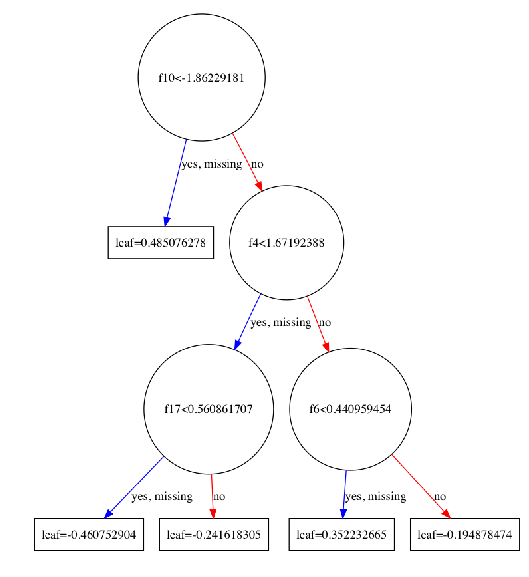

In [328]:
ax = plot_tree(usc.model_stack[1],num_trees=0)
fig = ax.figure
fig.set_size_inches(10,10)

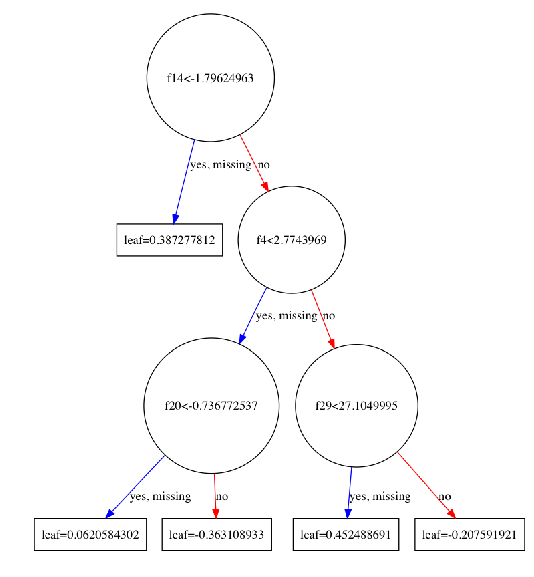

In [329]:
ax = plot_tree(usc.model_stack[1],num_trees=1)
fig = ax.figure
fig.set_size_inches(10,10)